In [96]:
import argparse
import musdb
import museval
import test
import multiprocessing
import functools
from pathlib import Path
import torch
import tqdm
import numpy as np
%matplotlib inline

In [169]:
model = 'umxhq'
model_name = 'umxhq'
#model = '../out_unmix/model_new_data_aug'
#model_name = 'model_new_data_aug'
# model = '../out_unmix/model_new_data'
# model_name = 'model_new_data'

# model = '../out_unmix/model8'
# model_name = 'model8'

targets = ['vocals']
outdir = '../test_out/BSS_eval_plots/'
evaldir = '../out_dir_evals/Exp1_umxhq'
root = '../test_out/Exp_1/exp1_tracks/'
subset = 'train'
cores = 1
no_cuda = False
is_wav = True

In [170]:
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [171]:
mus = musdb.DB(
    root=root,
    download=root is None,
    subsets=subset,
    is_wav=is_wav
)

In [172]:
mus.tracks

[Yaman_res_plus_comp50_t,
 Yaman_res_plus_comp85_t,
 musdb_eg1,
 my_data_eg1,
 my_data_eg2,
 osf_malhar]

In [173]:
track = mus.tracks[1]
'''0 - Yaman+comp50 == test data
   1 - musdb-eg
   2 - Sakhi_mori == train data
   3 - yaman+comp__ == valid data
   4 - osf_malhar
'''


'0 - Yaman+comp50 == test data\n   1 - musdb-eg\n   2 - Sakhi_mori == train data\n   3 - yaman+comp__ == valid data\n   4 - osf_malhar\n'

In [174]:
track.audio.shape

(4672680, 2)

In [175]:
estimates = test.separate(
    audio=track.audio,
    targets=targets,
    model_name=model,
    niter=2,
    alpha=1,
    softmask=False,
    #device=device
)

  0%|          | 0/1 [00:00<?, ?it/s]

CHECK OpenUnmix(
  (stft): STFT()
  (spec): Spectrogram()
  (transform): Sequential(
    (0): STFT()
    (1): Spectrogram()
  )
  (fc1): Linear(in_features=2974, out_features=512, bias=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(512, 256, num_layers=3, dropout=0.4, bidirectional=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=False)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=4098, bias=False)
  (bn3): BatchNorm1d(4098, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


In [176]:
audio_estimates = []
audio_reference = []
eval_targets = []

In [177]:
for key, target in list(track.targets.items()):
    try:
        # try to fetch the audio from the user_results of a given key
        estimates[key]
    except KeyError:
        # ignore wrong key and continue
        continue
    eval_targets.append(key)

In [178]:
mode='v4'
win=1.0
hop=1.0
data = museval.aggregate.TrackStore(win=win, hop=hop, track_name=track.name)

In [179]:
# check if vocals and accompaniment is among the targets
has_acc = all(x in eval_targets for x in ['vocals', 'accompaniment'])
if has_acc:
    # remove accompaniment from list of targets, because
    # the voc/acc scenario will be evaluated separately
    eval_targets.remove('accompaniment')


In [180]:
audio_estimates.append(estimates['vocals'])
audio_reference.append(track.targets['vocals'].audio)

In [181]:
def pad_or_truncate(
    audio_reference,
    audio_estimates
):
    """Pad or truncate estimates by duration of references:
    - If reference > estimates: add zeros at the and of the estimated signal
    - If estimates > references: truncate estimates to duration of references

    Parameters
    ----------
    references : np.ndarray, shape=(nsrc, nsampl, nchan)
        array containing true reference sources
    estimates : np.ndarray, shape=(nsrc, nsampl, nchan)
        array containing estimated sources
    Returns
    -------
    references : np.ndarray, shape=(nsrc, nsampl, nchan)
        array containing true reference sources
    estimates : np.ndarray, shape=(nsrc, nsampl, nchan)
        array containing estimated sources
    """
    est_shape = audio_estimates.shape
    ref_shape = audio_reference.shape
    if est_shape[1] != ref_shape[1]:
        if est_shape[1] >= ref_shape[1]:
            audio_estimates = audio_estimates[:, :ref_shape[1], :]
        else:
            # pad end with zeros
            audio_estimates = np.pad(
                audio_estimates,
                [
                    (0, 0),
                    (0, ref_shape[1] - est_shape[1]),
                    (0, 0)
                ],
                mode='constant'
            )

    return audio_reference, audio_estimates

In [182]:
def evaluate(
    references,
    estimates,
    win=1*44100,
    hop=1*44100,
    mode='v4',
    padding=True
):
    """BSS_EVAL images evaluation using metrics module

    Parameters
    ----------
    references : np.ndarray, shape=(nsrc, nsampl, nchan)
        array containing true reference sources
    estimates : np.ndarray, shape=(nsrc, nsampl, nchan)
        array containing estimated sources
    window : int, defaults to 44100
        window size in samples
    hop : int
        hop size in samples, defaults to 44100 (no overlap)
    mode : str
        BSSEval version, default to `v4`
    Returns
    -------
    SDR : np.ndarray, shape=(nsrc,)
        vector of Signal to Distortion Ratios (SDR)
    ISR : np.ndarray, shape=(nsrc,)
        vector of Source to Spatial Distortion Image (ISR)
    SIR : np.ndarray, shape=(nsrc,)
        vector of Source to Interference Ratios (SIR)
    SAR : np.ndarray, shape=(nsrc,)
        vector of Sources to Artifacts Ratios (SAR)
    """

    estimates = np.array(estimates)
    references = np.array(references)

    if padding:
        references, estimates = pad_or_truncate(references, estimates)

    SDR, ISR, SIR, SAR, _ = museval.metrics.bss_eval(
        references,
        estimates,
        compute_permutation=False,
        window=win,
        hop=hop,
        framewise_filters=(mode == "v3"),
        bsseval_sources_version=False
    )

    return SDR, ISR, SIR, SAR

In [183]:
SDR, ISR, SIR, SAR = evaluate(
        audio_reference,
        audio_estimates,
        win=int(win*track.rate),
        hop=int(hop*track.rate),
        mode=mode
    )

In [184]:
from matplotlib import pyplot as plt

No handles with labels found to put in legend.


{'whiskers': [<matplotlib.lines.Line2D at 0x7f8050ad3978>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8050add048>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8050ad3668>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8050add6d8>],
 'fliers': [],
 'means': []}

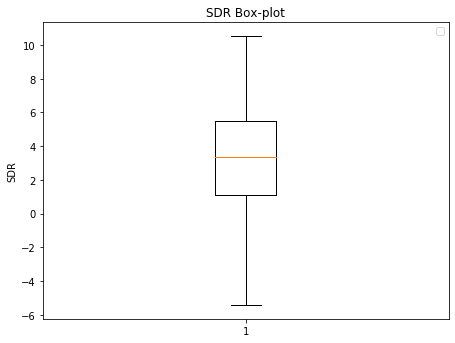

In [185]:
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 2)
plt.title("SDR Box-plot")
plt.ylabel("SDR")
plt.legend()
#plt.subplot(1,2,1)
plt.boxplot(SDR[0] , showfliers=False)
#plt.subplot(1,2,2)
#plt.boxplot(ISR[0])

#plt.savefig(outdir + "SDR_plot_" + track.name + "_" + model_name + ".pdf" )

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8050a2cd68>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8050a384a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8050a2ca58>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8050a38b38>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8050a38e80>],
 'means': []}

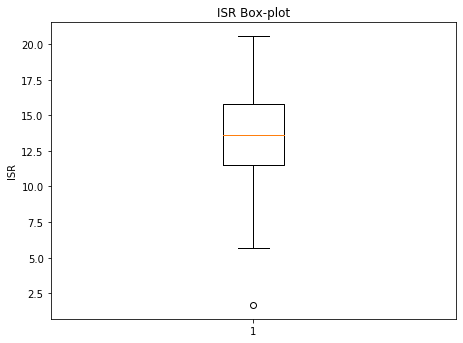

In [186]:
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 2)
plt.title("ISR Box-plot")
plt.ylabel("ISR")
plt.boxplot(ISR[0])
#plt.savefig(outdir + "ISR_plot_" + track.name + "_" + model_name + ".pdf" )

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8050a14358>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8050a14a58>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8050a14208>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8050a1b128>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8050a1b470>],
 'means': []}

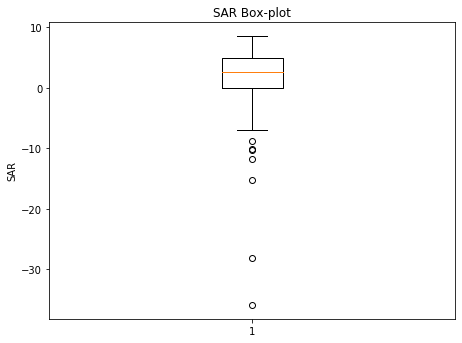

In [187]:
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 2)
plt.title("SAR Box-plot")
plt.ylabel("SAR")
plt.boxplot(SAR[0])
#plt.savefig(outdir + "SAR_plot_" + track.name + "_" + model_name + ".pdf" )

In [188]:
type(track.name)

str

In [189]:
np.median(SDR[0])

3.3733240642568214